In this third work we consider some simple regressions on the SPX metric.

In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import os

os.chdir('data')

In [2]:
# get SPX (sum of previous data)
data = pd.DataFrame()

for name in os.listdir('.'):
    if '.csv' in name and name != 'VIX.csv':
        raw = pd.read_csv(name, index_col=0, parse_dates=True)
        add = pd.DataFrame(raw['close'])
        data = data.add(add, axis=0, fill_value=0)
data.rename({'close':'SPX'},axis=1,inplace=True)
display(data.head())
display(data.describe())

,SPX
date,
2014-02-21,2043.3871
2014-02-24,2056.1417
2014-02-25,2051.1438
2014-02-26,2053.2382
2014-02-27,2066.4070


,SPX
count,1258.000000
mean,2768.968118
std,569.045340
min,2042.883700
25%,2319.402900
50%,2491.279400
75%,3355.089050
max,3918.542500


First we consider polynomial fits of different degrees and see how they compare in modeling the SPX data.
These fits are computed through the straight-forward method of least squares.

Text(0.5, 1.0, 'SPX with regressions of deg 1,2,3,4')

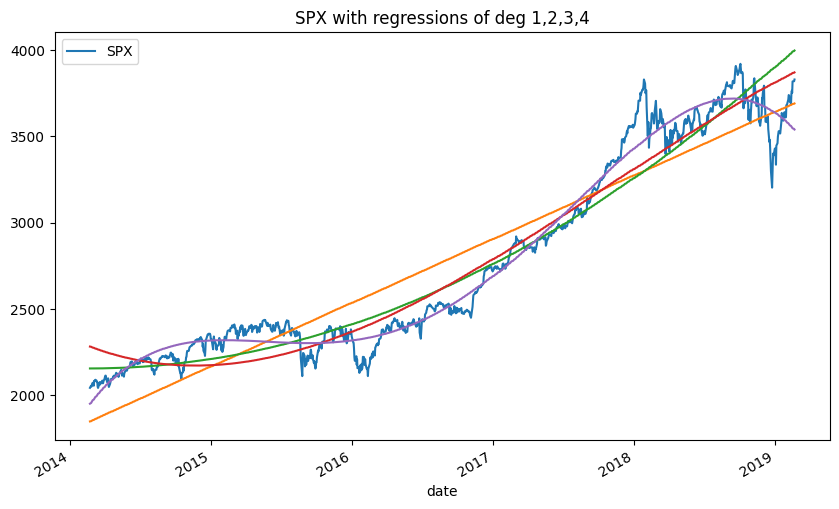

In [3]:
# regressions of degree 1,2,3,4
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data.plot(ax=ax)

for deg in [1,2,3,4]:
    reg_data = data.reset_index()
    reg = np.polyfit(reg_data.index, data.SPX, deg=deg)
    ax.plot(data.index, np.polyval(reg, reg_data.index))

ax.set_title('SPX with regressions of deg 1,2,3,4')

We can see above that this method is by no means a good method to model the curve, but we try with another example.
We use a slightly more general method of constructing a base matrix in which each row is a basis, ie. constant 1s, x, x^2, x^3, etc.
In this case, just for fun, we also set as bases the stocks of AAPL and NKE to see if they can play a significant role in modelling the SPX.

1 has weight 1808.336
x^1 has weight 1.506
x^2 has weight 0.346
AAPL has weight 6.345
NKE has weight -5.471


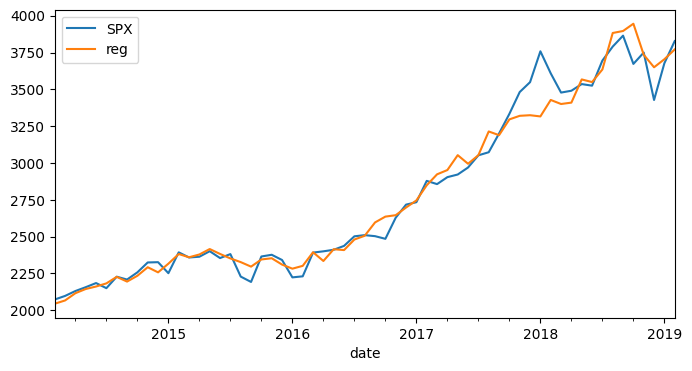

In [4]:
# regression on monthly data using AAPL and NKE stocks 

m_data = data.resample('1m',label='right').last()
m_reg_data = m_data.reset_index()

aapl = pd.read_csv('AAPL.csv', index_col=0, parse_dates=True)
m_aapl = aapl.close.resample('1m',label='right').last()
nke = pd.read_csv('NKE.csv', index_col=0, parse_dates=True)
m_nke = nke.close.resample('1m',label='right').last()

deg = 2
stocks = 2
base = np.zeros((deg+1+stocks, len(m_data.SPX)))
for i in range(0,deg+1):
    base[i,:] = np.power(m_reg_data.index, i)

base[deg+1,:] = m_aapl
base[deg+2,:] = m_nke

reg = np.linalg.lstsq(base.T, m_data.SPX, rcond=None)[0]
m_data['reg'] = np.dot(reg, base)

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

m_data.plot(ax=ax)

bases = ['1','AAPL','NKE']
for i in range(1,deg+1):
    bases.insert(i,'x^'+str(i))

for i in range(0,deg+1+stocks):
    print(f"{bases[i]} has weight {round(reg[i],3)}")

Naturally we can see that this method of combining a polynomial and these two stocks to model the SPX is not too accurate.
Interestingly AAPL has a positive weight and NKE a negative weight, meaning that over the whole period AAPL has moved with the SPX market and NKE against it.

To conclude we consider a final example where this time the basis on which to model the regression is made up of lagged versions of the same SPX data.
That is we lag the SPX data by 1, 2, 3 etc and use this lagged data as the basis.
The result is rather understandably that the data lagged by only 1 is by far the most heavily used, and all others have much smaller weights.

lag 1 has weight 0.875
lag 2 has weight 0.133
lag 3 has weight -0.213
lag 4 has weight 0.056
lag 5 has weight 0.164


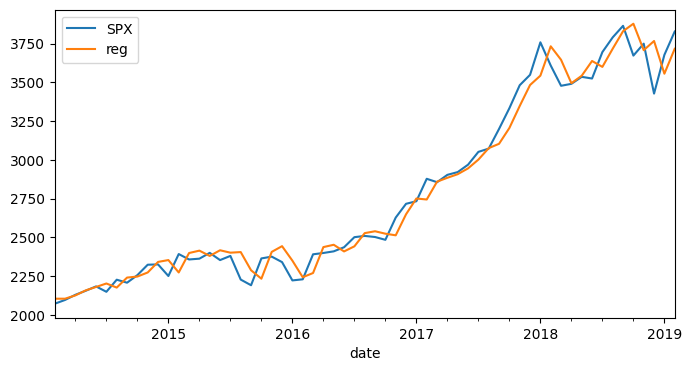

In [57]:
# regression on monthly data using AAPL and NKE stocks 

m_data = data.resample('1m',label='right').last()
m_reg_data = m_data.reset_index()
lags = 5
base = np.ones((lags, len(m_data.SPX)))

for i in range(0,lags):
    row = m_reg_data.SPX.shift(i+1)
    for j in range(0,i+1):
        row[j] = row[i+1]
    base[i,:] = row

reg = np.linalg.lstsq(base.T, m_data.SPX, rcond=None)[0]
m_data['reg'] = np.dot(reg, base)

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

m_data.plot(ax=ax)

for i in range(1,lags+1):
    print(f"lag {i} has weight {round(reg[i-1],3)}")